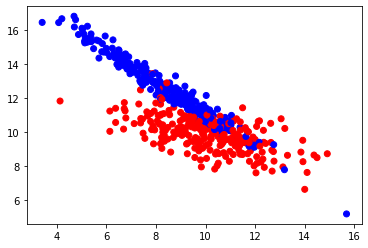

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
import matplotlib
import matplotlib.pyplot as plt

X,Y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, 
                          n_classes=2, n_clusters_per_class=1, weights=None, flip_y=0, class_sep=30.0,
                          hypercube=False,shift=5.0, scale=2.0, shuffle=True,random_state=1)

colors=['red','blue']
plt.scatter(x=X[:,0],y=X[:,1],c=Y,cmap=matplotlib.colors.ListedColormap(colors))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
def sigmoid(z):
  return 1/(1+np.exp(-z))

def normalPDF(x,mu,sigma):
  num = np.exp(-1/2*((x-mu)/sigma)**2)
  den = np.sqrt(2*np.pi)*sigma
  return num/den

def bernoulli(p,y):
  return (p)**y * (1-p)**(1-y)  

def logreg_mcmc(X,Y,hops=10_000):  
  samples = []
  curr_b0 = 0
  curr_b1 = 0
  curr_b2 = 0

  prior_curr_b0 = normalPDF(x=curr_b0,mu=1,sigma=1)
  prior_curr_b1 = normalPDF(x=curr_b1,mu=1,sigma=1)
  prior_curr_b2 = normalPDF(x=curr_b2,mu=1,sigma=1)

  P = [sigmoid(z= curr_b1 * x1 + + curr_b2 * x2 + curr_b0) for x1,x2, in X]
  curr_log_lik = sum([np.log(bernoulli(p=pi,y=yi)) for pi,yi in zip(P,Y)])
  current = curr_log_lik + np.log(prior_curr_b0) + np.log(prior_curr_b1) + np.log(prior_curr_b2) 

  count = 0
  for i in range(hops):
    samples.append((curr_b0,curr_b1,curr_b2))
    
    if count == 0:
      mov_b0 = curr_b0 + random.uniform(-0.25,0.25)
      mov_b1 = curr_b1
      mov_b2 = curr_b2
      count +=1

    elif count == 1:
      mov_b0 = curr_b0 
      mov_b1 = curr_b1 + random.uniform(-0.25,0.25)     
      mov_b2 = curr_b2
      count += 1 

    else:
      mov_b0 = curr_b0 
      mov_b1 = curr_b1 
      mov_b2 = curr_b2 + random.uniform(-0.25,0.25)
      count = 0          

        
    prior_mov_b0 = normalPDF(x=mov_b0,mu=1,sigma=1)
    prior_mov_b1 = normalPDF(x=mov_b1,mu=1,sigma=1)
    prior_mov_b2 = normalPDF(x=mov_b2,mu=1,sigma=1)

    P = [sigmoid(z= mov_b1 * x1 + + mov_b2 * x2 + mov_b0) for x1,x2, in X]
    mov_log_lik = sum([np.log(bernoulli(p=pi,y=yi)) for pi,yi in zip(P,Y)])
    movement = mov_log_lik + np.log(prior_mov_b0) + np.log(prior_mov_b1) + np.log(prior_mov_b2) 

    ratio = np.exp(movement - current)
    event = random.uniform(0,1)
    if event <= ratio:
      curr_b0 = mov_b0
      curr_b1 = mov_b1
      curr_b2 = mov_b2
      current = movement
      
  return samples

In [4]:
test = logreg_mcmc(X,Y,hops=5000)

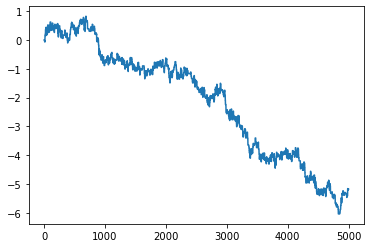

In [5]:
def trace(data,index):
  x = [i for i in range(len(data))]
  y = [data[i][index] for i in range(len(data))]
  plt.plot(x,y)

trace(test,0)

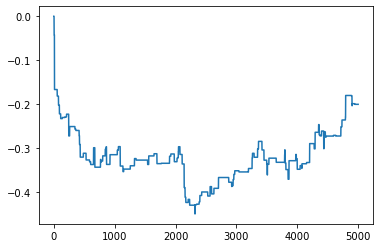

In [6]:
trace(test,1)

In [ ]:
import numpy as np
import random
import scipy.stats as st
import matplotlib.pyplot as plt

def normal(x,mu,sigma):
    numerator = np.exp(-1*((x-mu)**2)/(2*sigma**2))
    denominator = sigma * np.sqrt(2*np.pi)
    return numerator/denominator

def neg_log_prob(x,mu,sigma):
    return -1*np.log(normal(x=x,mu=mu,sigma=sigma))

def HMC(mu=0.0,sigma=1.0,path_len=1,step_size=0.25,initial_position=0.0,epochs=1_000):
    # setup
    steps = int(path_len/step_size) # path_len and step_size are tricky parameters to tune...
    samples = [initial_position]
    momentum_dist = st.norm(0, 1) 
    # generate samples
    for e in range(epochs):
        q0 = np.copy(samples[-1])
        q1 = np.copy(q0)
        p0 = momentum_dist.rvs()        
        p1 = np.copy(p0) 
        dVdQ = -1*(q0-mu)/(sigma**2) # gradient of PDF wrt position (q0) aka potential energy wrt position

        # leapfrog integration begin
        for s in range(steps): 
            p1 += step_size*dVdQ/2 # as potential energy increases, kinetic energy decreases, half-step
            q1 += step_size*p1 # position increases as function of momentum 
            p1 += step_size*dVdQ/2 # second half-step "leapfrog" update to momentum    
        # leapfrog integration end        
        p1 = -1*p1 #flip momentum for reversibility     

        
        #metropolis acceptance
        q0_nlp = neg_log_prob(x=q0,mu=mu,sigma=sigma)
        q1_nlp = neg_log_prob(x=q1,mu=mu,sigma=sigma)        

        p0_nlp = neg_log_prob(x=p0,mu=0,sigma=1)
        p1_nlp = neg_log_prob(x=p1,mu=0,sigma=1)
        
        # Account for negatives AND log(probabiltiies)...
        target = q0_nlp - q1_nlp # P(q1)/P(q0)
        adjustment = p1_nlp - p0_nlp # P(p0)/P(p1)
        acceptance = target + adjustment # [P(q1)*P(p0)]/[P(q0)*P(p1)] 
        
        event = np.log(random.uniform(0,1))
        if event <= acceptance:
            samples.append(q1)
        else:
            samples.append(q0)
    
    return samples
        